In [28]:
using Statistics
using Distributions
using QuadGK
using Symbolics
using Plots
using DataFrames
using PlotThemes

include("LaTexTools.jl")
using .LaTexTools

In [29]:
function is_well_defined(dist::Distribution)
    lower = minimum(dist)
    return isfinite(lower) && lower ≥ 0
end

function is_symmetric(dist::Distribution)
    μ = mean(dist)
    return pdf(dist, μ + 1.0) == pdf(dist, μ - 1.0)
end

is_symmetric (generic function with 1 method)

In [30]:
function fractional_moment(dist::Distribution, α::Real; use_abs=false, complex=false)
    if dist isa ContinuousUnivariateDistribution
        lower = minimum(dist)
        upper = maximum(dist)
        print(lower)
        if !isfinite(lower)
            lower = -1000
            print(lower)
            if lower < 0 && is_symmetric(dist)
                lower = 0
            end
        elseif lower < 0 && is_symmetric(dist)
            print("ok")
            lower = 0
        elseif lower < 0
            lower = -1000
        end

        if !isfinite(upper)
            upper = 1000
        end

        integrand(x) = begin
            val = use_abs ? abs(x) : (complex ? (x + 0im) : x)
            val^α * pdf(dist, x)
        end

        moment, _ = quadgk(integrand, lower, upper)
        return is_symmetric(dist) ? 2 * moment : moment

    elseif dist isa DiscreteUnivariateDistribution
        support_vals = 0:1000
        return sum(begin
            val = use_abs ? abs(x) : (complex ? (x + 0im) : x)
            val^α * pdf(dist, x)
        end for x in support_vals)
    else
        throw(ArgumentError("Distribution type not supported"))
    end
end

fractional_moment (generic function with 1 method)

In [31]:
function fractional_moment_CF(dist::Distribution, α::Real; use_abs=false, complex=false)
    n = floor(α)
    β = α - n

    if dist isa ContinuousUnivariateDistribution
        lower = minimum(dist)
        upper = maximum(dist)

        if !isfinite(lower)
            lower = -1000
            if lower < 0 && is_symmetric(dist)
                lower = 0
            end
        elseif lower < 0 && is_symmetric(dist)
            lower = 0
        elseif lower < 0
            lower = -1000
        end

        if !isfinite(upper)
            upper = 1000
        end

        integrand(x) = begin
            ε = 1e-10
            val = use_abs ? abs(x) : (complex ? (x + 0im) : x)
            numer = val^(n + 1)
            denom = (1 - β) * val + β + ε
            numer / denom * pdf(dist, x)
        end

        moment, _ = quadgk(integrand, lower, upper)
        print(moment)
        return is_symmetric(dist) ? 2 * moment : moment
    elseif dist isa DiscreteUnivariateDistribution
        support_vals = 0:1000
        return sum(begin
            ε = 1e-10
            val = use_abs ? abs(x) : (complex ? (x + 0im) : x)
            numer = val^(n + 1)
            denom = (1 - β) * val + β + ε
            numer / denom * pdf(dist, x)
        end for x in support_vals)
    else
        throw(ArgumentError("Distribution type not supported"))
    end
end


fractional_moment_CF (generic function with 1 method)

In [32]:
betas = [0.5, 1, 1.5, 2]

alphas = range(0.001, 5, length=500)
all_differences = Dict{Float64,Vector{Float64}}()
statistics = Dict{Float64,Vector{Float64}}()
for β in betas
    E = Exponential(β)
    difference = []
    for α in alphas
        push!(difference, fractional_moment(E, α) - fractional_moment_CF(E, α))
    end
    all_differences[β] = difference
    statistics[β] = [minimum(all_differences[β]), maximum(all_differences[β]), mean(all_differences[β]), std(all_differences[β]), skewness(all_differences[β]), std(all_differences[β]) / mean(all_differences[β])]
end

stat_df = DataFrame(
    beta=Float64[],
    minimum=Float64[],
    maximum=Float64[],
    mean=Float64[],
    standard_deviation=Float64[],
    skewness=Float64[],
    coefficient_of_variation=Float64[]
)


for β in sort(collect(keys(statistics)))
    stats = statistics[β]
    push!(stat_df, (β, stats[1], stats[2], stats[3], stats[4], stats[5], stats[6]))
end

stat_df .= round.(stat_df, digits=3)

#save_latex_table(stat_df, "Summary Statistics", "tables/exp_statistics_table")


0.00.98967898272527290.00.93629357874686490.00.90176793975757450.00.87453669153596640.00.85169352962028990.00.83188868490507710.00.81435221918155150.00.79859236838730820.00.78427127584478160.00.77114458859702260.00.75902867823156610.00.7477813829888270.00.7372899909122610.00.72746337695542560.00.71822665661201590.00.70951743326024030.00.70128309271800630.00.6934788076887590.00.68606603645722750.00.67901137375944080.00.67228565773259420.00.66586326643644470.00.65972155696694870.00.6538404133687480.00.6482018786381390.00.64278985248261010.00.63758984104986870.00.63258874813130260.00.6277746997611310.00.62313689592835320.00.61866548446879310.00.6143514532305150.00.61018653739320430.00.60616313943185880.00.60227425969139370.00.59851343591373450.00.59487469035640860.00.59135248337922850.00.58794167256668860.00.58463747660825880.00.58143544328452030.00.57833142101002290.00.57532153346839710.00.57240215694525280.00.56956990002252890.00.56682158534646830.00.56415423322203340.00.561565046820787

Row,beta,minimum,maximum,mean,standard_deviation,skewness,coefficient_of_variation
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.5,0.0,0.329,0.074,0.083,1.762,1.12
2,1.0,0.0,22.119,2.907,5.612,2.314,1.93
3,1.5,0.0,225.731,25.477,54.91,2.513,2.155
4,2.0,0.0,1128.26,115.489,265.154,2.655,2.296


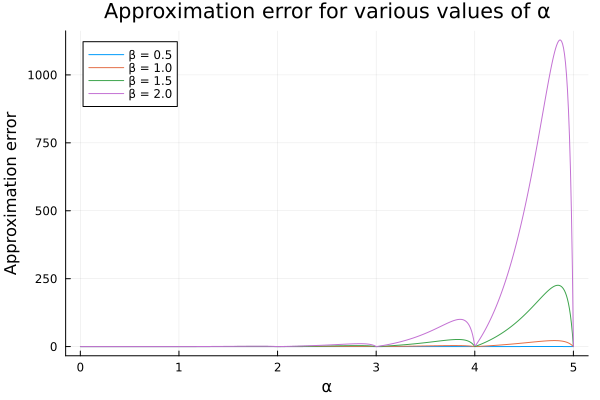

In [34]:
plt = plot(title="Approximation error for various values of α", xlabel="α", ylabel="Approximation error", legend=:topleft)
for β in betas
    plot!(plt, alphas, all_differences[β], label="β = $β")
end
display(plt)

#savefig(plt, "latex_project/figures/error_plot_exp.pdf")

In [35]:
mus = [0, 2]
sigmas = [1, sqrt(2)]

alphas = range(-0.95, 5, length=500)
all_differences = Dict{Tuple{Float64,Float64},Vector{Float64}}()
statistics = Dict{Tuple{Float64,Float64},Vector{Float64}}()
for μ in mus
    for σ in sigmas
        N = Normal(μ, σ)
        difference = []
        for α in alphas
            push!(difference, fractional_moment(N, α) - fractional_moment_CF(N, α))
        end
        all_differences[(μ, σ)] = difference
        statistics[(μ, σ)] = [minimum(all_differences[(μ, σ)]), maximum(all_differences[(μ, σ)]), mean(all_differences[(μ, σ)]),
            std(all_differences[(μ, σ)]), skewness(all_differences[(μ, σ)]), std(all_differences[(μ, σ)]) / mean(all_differences[(μ, σ)])]
    end
end

stat_df = DataFrame(
    mu=Float64[],
    sigma=Float64[],
    minimum=Float64[],
    maximum=Float64[],
    mean=Float64[],
    standard_deviation=Float64[],
    skewness=Float64[],
    coefficient_of_variation=Float64[]
)


for (μ, σ) in sort(collect(keys(statistics)))
    stats = statistics[(μ, σ)]
    push!(stat_df, (μ, σ, stats[1], stats[2], stats[3], stats[4], stats[5], stats[6]))
end

stat_df .= round.(stat_df, digits=3)

#save_latex_table(stat_df, "Summary Statistics", "tables/normal_statistics_table")

-Inf-10001.2864672330358045-Inf-10001.2126246789738202-Inf-10001.1530921349686225-Inf-10001.1034758503696596-Inf-10001.061122445874176-Inf-10001.0243084911194482-Inf-10000.9918524658660359-Inf-10000.9629098503251166-Inf-10000.9368565955296876-Inf-10000.9132188803873798-Inf-10000.8916287294448209-Inf-10000.8717948587802841-Inf-10000.853482888773515-Inf-10000.836501534588719-Inf-10000.8206927336730266-Inf-10000.8059244380303422-Inf-10000.7920852537794533-Inf-10000.7790803885957531-Inf-10000.766828542678835-Inf-10000.755259491926604-Inf-10000.7443121866830208-Inf-10000.7339332397983651-Inf-10000.7240757123510662-Inf-10000.7146981295655214-Inf-10000.7057636766233389-Inf-10000.697239536418315-Inf-10000.6890963403124664-Inf-10000.681307709597154-Inf-10000.6738498703229197-Inf-10000.6667013279008-Inf-10000.6598425907240553-Inf-10000.6532559342452285-Inf-10000.6469251986365201-Inf-10000.6408356144831199-Inf-10000.6349736519985081-Inf-10000.6293268900738346-Inf-10000.6238839021295997-Inf-10000.

Row,mu,sigma,minimum,maximum,mean,standard_deviation,skewness,coefficient_of_variation
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,1.0,0.0,13.439,0.298,1.07,7.898,3.591
2,0.0,1.414,0.0,9.505,0.7,1.141,2.824,1.629
3,2.0,1.0,0.0,32.123,4.517,8.055,2.269,1.783
4,2.0,1.414,0.0,91.231,11.411,22.404,2.428,1.963


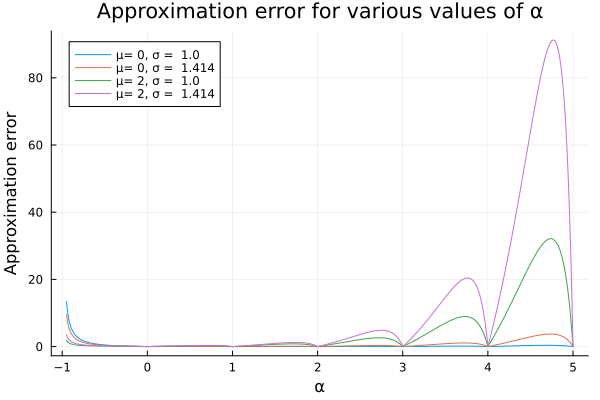

In [36]:
plt = plot(title="Approximation error for various values of α", xlabel="α", ylabel="Approximation error", legend=:topleft)
for μ in mus
    for σ in sigmas
        σ_display = round(σ, digits=3)
        plot!(plt, alphas, all_differences[(μ, σ)], label="μ= $μ, σ =  $σ_display")
    end
end
display(plt)

#savefig(plt, "latex_project/figures/error_plot_normal.pdf")

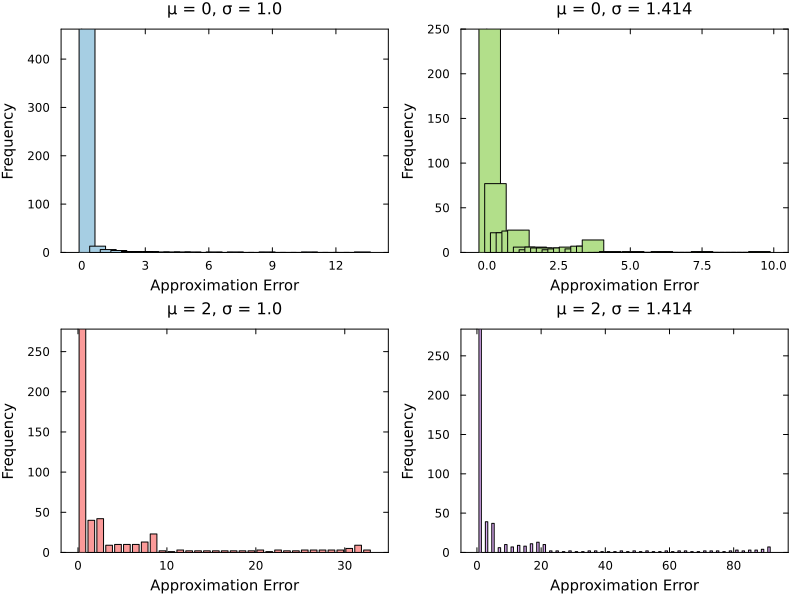

In [37]:
plt = plot(layout=(2, 2), size=(800, 600), title="Histograms of Approximation Errors")

colors = ["#A6CEE3", "#B2DF8A", "#FB9A99", "#D9A9F2"]
i = 1

for μ in mus
    for σ in sigmas
        errors = all_differences[(μ, σ)]

        histogram!(plt[i],
            errors,
            bins=50,
            xlabel="Approximation Error",
            ylabel="Frequency",
            title="μ = $μ, σ = $(round(σ, digits=3))",
            legend=false,
            normalize=false,
            bar_width=0.75,
            linecolor=:black,
            fillalpha=1,
            color=colors[i],
            framestyle=:box,
            grid=false,
            xguidefontsize=10,
            yguidefontsize=10,
            titlefontsize=11
        )
        i += 1
    end
end

display(plt)

#savefig(plt, "latex_project/figures/error_histogram.pdf")

In [38]:
lambdas = [0.5, 1, 1.5, 2]

alphas = range(0.001, 5, length=500)
all_differences = Dict{Float64,Vector{Float64}}()
statistics = Dict{Float64,Vector{Float64}}()
for λ in lambdas
    P = Poisson(λ)
    difference = []
    for α in alphas
        push!(difference, fractional_moment(P, α) - fractional_moment_CF(P, α))
    end
    all_differences[λ] = difference
    statistics[λ] = [minimum(all_differences[λ]), maximum(all_differences[λ]), mean(all_differences[λ]), std(all_differences[λ]), skewness(all_differences[λ]), std(all_differences[λ]) / mean(all_differences[λ])]
end

stat_df = DataFrame(
    lambda=Float64[],
    minimum=Float64[],
    maximum=Float64[],
    mean=Float64[],
    standard_deviation=Float64[],
    skewness=Float64[],
    coefficient_of_variation=Float64[]
)


for λ in sort(collect(keys(statistics)))
    stats = statistics[λ]
    push!(stat_df, (λ, stats[1], stats[2], stats[3], stats[4], stats[5], stats[6]))
end

stat_df .= round.(stat_df, digits=3)

#save_latex_table(stat_df, "Summary Statistics", "tables/poisson_statistics_table")

Row,lambda,minimum,maximum,mean,standard_deviation,skewness,coefficient_of_variation
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.5,0.0,0.715,0.128,0.191,1.915,1.494
2,1.0,0.0,6.5,1.021,1.713,2.075,1.679
3,1.5,0.0,26.904,3.895,7.001,2.176,1.797
4,2.0,0.0,78.34,10.687,20.143,2.251,1.885


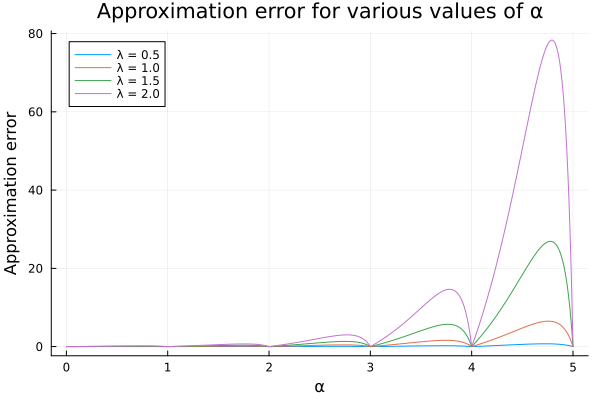

In [39]:
plt = plot(title="Approximation error for various values of α", xlabel="α", ylabel="Approximation error", legend=:topleft)
for λ in lambdas
    plot!(plt, alphas, all_differences[λ], label="λ = $λ")
end
display(plt)

#savefig(plt, "latex_project/figures/error_plot_poisson.pdf")

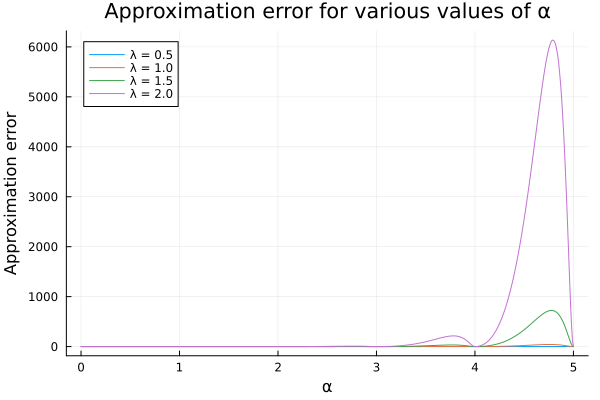

In [40]:
plt = plot(title="Approximation error for various values of α", xlabel="α", ylabel="Approximation error", legend=:topleft)
for λ in lambdas
    plot!(plt, alphas, all_differences[λ] .^ 2, label="λ = $λ")
end
display(plt)

#savefig(plt, "latex_project/figures/error_plot_poisson.pdf")